####   Exemple

In [1]:
from Classes_Both.module_marche import DonneeMarche
from Classes_MonteCarlo_LSM.module_brownian import Brownian
from Classes_MonteCarlo_LSM.module_LSM import LSM_method
from Classes_Both.module_option import Option
from Classes_Both.derivatives import OptionDerivatives, OptionDerivativesParameters
import datetime as dt
import numpy as np
import time
from Classes_TrinomialTree.module_arbre_noeud import Arbre
import matplotlib.pyplot as plt
import pandas as pd
from Classes_MonteCarlo_LSM.module_graph import LSMGraph

### Paramètre

In [2]:
start_date = dt.datetime(2025, 4, 4)
end_date = dt.datetime(2026, 4, 4)

market = DonneeMarche(date_debut= start_date,
volatilite=0.30, 
taux_interet=0.05, 
taux_actualisation=0.05,
# dividends=[{"ex_div_date": dt.datetime(2024, 4, 21), "amount": 3, "rate": 0}], 
dividende_ex_date = dt.datetime(2025, 1, 1),
dividende_montant = 0,
dividende_rate=0,
prix_spot=100)

optionA = Option(date_pricing=start_date, 
                maturite=end_date, 
                prix_exercice=100, call=False, americaine=True)

optionB = Option(date_pricing=start_date, 
                maturite=end_date, 
                prix_exercice=102, call=False, americaine=True)
# bermudien, 4 de chaque mois, donc mettre 1 pas de temps à chaque mois

optionC = Option(date_pricing=start_date, 
                maturite=end_date, # ici prix strike inultile, et type call put inutile
                prix_exercice=107, call=True, americaine=True)

pricer = LSM_method(optionA)

# nombre d'année entre début et fin 
period = (end_date - start_date).days / 365
nb_pas_arbre = 1000
arbre = Arbre(nb_pas_arbre, market, optionA, pruning = True)
arbre.pricer_arbre()

print(f"Prix arbre option {arbre.prix_option}")

Prix arbre option 9.867787904968338


### Test solo

In [3]:
nb_pas = 252 #12 #10000 #int((end_date - start_date).days / 2)*2
nb_chemin = 100000
seed = 1
method = 'vector'        # vector ou scalar
model_type="Polynomial"  # "Polynomial" "laguerre" "hermite" "legendre" "chebyshev"
degree_polynome = 3      # utile pour polynomial, laguerre, hermite, legendre, chebyshev

brownian = Brownian(period, nb_pas, nb_chemin, seed)
price, std_error, intervalle = pricer.LSM(brownian, market, method=method, 
                              antithetic=False,poly_degree=degree_polynome, model_type=model_type,
                              print_info = True)
print("Prix: ", price)
print("Ecart type: ", std_error)
print("Intervalle de confiance: ", intervalle)     


Nb chemins non antithetic: 100000
Prix min ('non antithetic', 'américaine', 'vector'): 9.757828442967178
Prix max ('non antithetic', 'américaine', 'vector'): 9.895841487946477
Prix:  9.826834965456827
Ecart type:  0.03450326124482466
Intervalle de confiance:  (np.float64(9.757828442967178), np.float64(9.895841487946477))


In [4]:
brownian = Brownian(period, nb_pas, nb_chemin, seed)
price_ant, std_error_ant, intervalle_ant = pricer.LSM(brownian, market, method=method, 
                              antithetic=True,poly_degree=degree_polynome, model_type=model_type,
                              print_info = True)
print("Prix: ", price_ant)
print("Ecart type: ", std_error_ant)
print("Intervalle de confiance: ", intervalle_ant)

#std_error_ant / std_error - 1 # reduction ecart type

Nb chemins antithetic: 10000
Prix min ('antithetic', 'américaine', 'vector'): 9.78198756855941
Prix max ('antithetic', 'américaine', 'vector'): 9.946539856658331
Prix:  9.86426371260887
Ecart type:  0.04113807202473005
Intervalle de confiance:  (np.float64(9.78198756855941), np.float64(9.946539856658331))


### Itération nombre pas et chemin

In [ ]:
###### test boucle
from itertools import product
liste_chemin = [10000 * i for i in range(1, 11)]
liste_pas_chemin = [(10000 * i, int((end_date - start_date).days / 2)) for i in range(1, 11)]
liste_pas = [10 * i for i in range(1, 31)]
combinations = list(product(liste_chemin,liste_pas))
dico_price = {}

def test_boucle(combi):
    for (path,pas) in combi:
        brownian = Brownian(period, pas, path, 1)
        price, std_error, intervalle = pricer.LSM(brownian, market, method='vector', antithetic=True, 
                                                  poly_degree=2, model_type="polynomial",
                                                  print_info = False)
        if intervalle[0] <= arbre.prix_option <= intervalle[1]:
            if int(arbre.prix_option * 100) / 100 == int(price * 100) / 100:# and std_error < 0.01:
                dico_price[(pas,path)] = {'vrai prix': arbre.prix_option,'price': round(price, 4) ,'ecart-type': round(std_error, 4), 
                'min': round(intervalle[0], 4), 'max':round(intervalle[1], 4), 'proche': "✅    "}
                break
            if int(price * 100) / 100 - 0.01 <= int(arbre.prix_option * 100) / 100 <= int(price * 100) / 100 + 0.01:# and std_error < 0.01:
                dico_price[(pas,path)] = {'vrai prix': arbre.prix_option,'price': round(price, 4) ,'ecart-type': round(std_error, 4), 
                'min': round(intervalle[0], 4), 'max':round(intervalle[1], 4),'proche':'❌    '}
        print(pas,path, price)

test_boucle(combinations)
test_boucle(liste_pas_chemin)
pd.DataFrame(dico_price)

10 10000 10.252561959718344
20 10000 10.24955386579374
30 10000 10.367117168656707
40 10000 10.576852400488375
50 10000 10.545147404644506
60 10000 10.572537461042511
70 10000 10.63403575603293
80 10000 10.698433115334879
90 10000 10.70061894970842
100 10000 10.745428859842105
110 10000 10.783574223732154
120 10000 10.789729203076806
130 10000 10.791381853999168
140 10000 10.861213609906988
150 10000 10.856888882653035
160 10000 10.819008194014334
170 10000 10.766966575531223
180 10000 10.827560877734955
190 10000 10.815424509224764
200 10000 10.82252016479841
210 10000 10.834142283567573
220 10000 10.859427239047422
230 10000 10.88377208619735
240 10000 10.846205000097983
250 10000 10.853774508496791


In [ ]:
nb_pas = int((end_date - start_date).days / 2)
nb_chemin = 10000
seed = 1
method = 'vector'        # vector ou scalar
model_type="polynomial"  # "polynomial" "laguerre" "hermite" "legendre" "chebyshev"
degree_polynome = 2      # utile pour polynomial, laguerre, hermite, legendre, chebyshev

# non antithetic
brownian = Brownian(period, nb_pas, nb_chemin, seed)
price, std_error_non_antithetic, intervalle = pricer.LSM(brownian, market, method=method, 
                              antithetic=False,poly_degree=degree_polynome, model_type=model_type,
                              print_info = True)

# antithetic
brownian = Brownian(period, nb_pas, nb_chemin, seed)
price_antithetic, std_error_antithetic, intervalle = pricer.LSM(brownian, market, method=method, 
                              antithetic=True,poly_degree=degree_polynome, model_type=model_type,
                              print_info = True)
print("Prix: ", price, std_error_non_antithetic)
print("Prix antithetic: ", price_antithetic, std_error_antithetic)
std_error_antithetic/std_error_non_antithetic - 1


Nb chemins non antithetic: 10000
Prix min ('non antithetic', 'américaine', 'vector'): 14.206988140219405
Prix max ('non antithetic', 'américaine', 'vector'): 15.024044644362519
Nb chemins antithetic: 10000
Prix min ('antithetic', 'américaine', 'vector'): 14.424295704137034
Prix max ('antithetic', 'américaine', 'vector'): 14.810330706710904
Prix:  14.615516392290962 0.20426412603577876
Prix antithetic:  14.617313205423969 0.09650875064346773


-0.5275296131707272

### Grecques

In [4]:
pricer_options = {
    "method": "vector",
    "poly_degree": 3,
    "model_type": "Polynomial",
    "antithetic": True
}

brownian = Brownian(period, nb_pas, nb_chemin, seed)

option_deriv = OptionDerivatives(optionA, market, pricer, pricer_options)
 
#print("Prix :", option_deriv.price(option_deriv.parameters))
print("Delta :", option_deriv.delta(brownian))
print("Vega :", option_deriv.vega(brownian)/100)
print("Theta :", option_deriv.theta(brownian)/100)
print("Rho :", option_deriv.rho(brownian)/100)
print("Gamma :", option_deriv.gamma(brownian))
print("Vomma :", option_deriv.vomma(brownian)/100)


Delta : -0.41001144235536024
Vega : 0.38079239763582157
Theta : -0.03983294330903138
Rho : -0.3459408933827266
Gamma : 0.009438057679969969
Vomma : 0.02707124184437859


### Graphiques

In [4]:
# Initialisation de la classe avec les objets option et marché
lsm_graph = LSMGraph(option=optionA, market=market)

C:\Users\User\AppData\Local\Temp\ipykernel_52056\3229506433.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_prix.show()


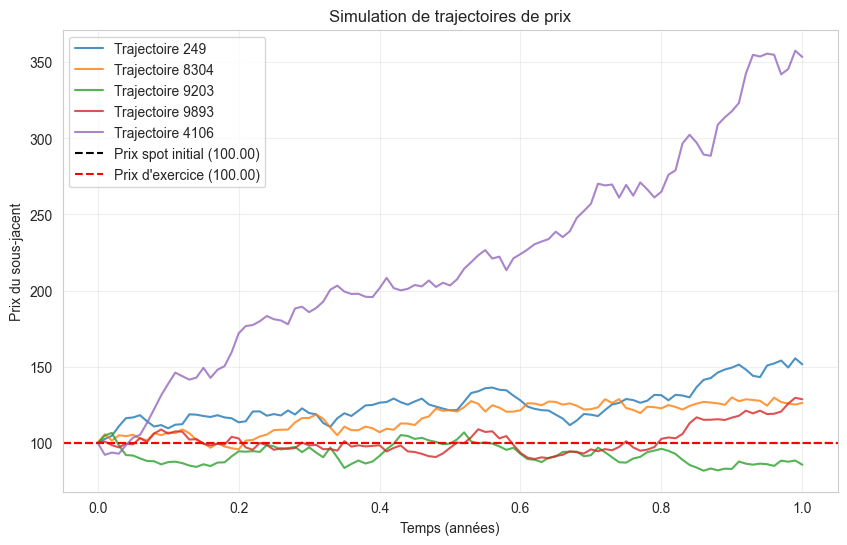

In [5]:
# Génération des trajectoires
trajectoires = pricer.Price(market, brownian)

# Pour afficher uniquement les trajectoires de prix
fig_prix = lsm_graph.afficher_trajectoires_prix(trajectoires, brownian)
fig_prix.show()

C:\Users\User\AppData\Local\Temp\ipykernel_52620\1423160215.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_brownian.show()


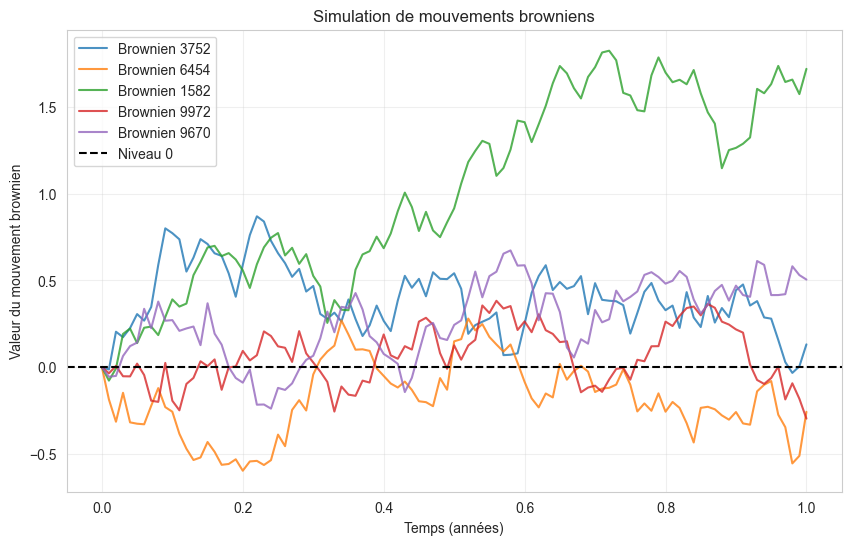

In [6]:
# Pour afficher uniquement les mouvements browniens
fig_brownian = lsm_graph.afficher_mouvements_browniens(brownian)
fig_brownian.show()

C:\Users\User\AppData\Local\Temp\ipykernel_52056\3472671309.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_methodes.show()


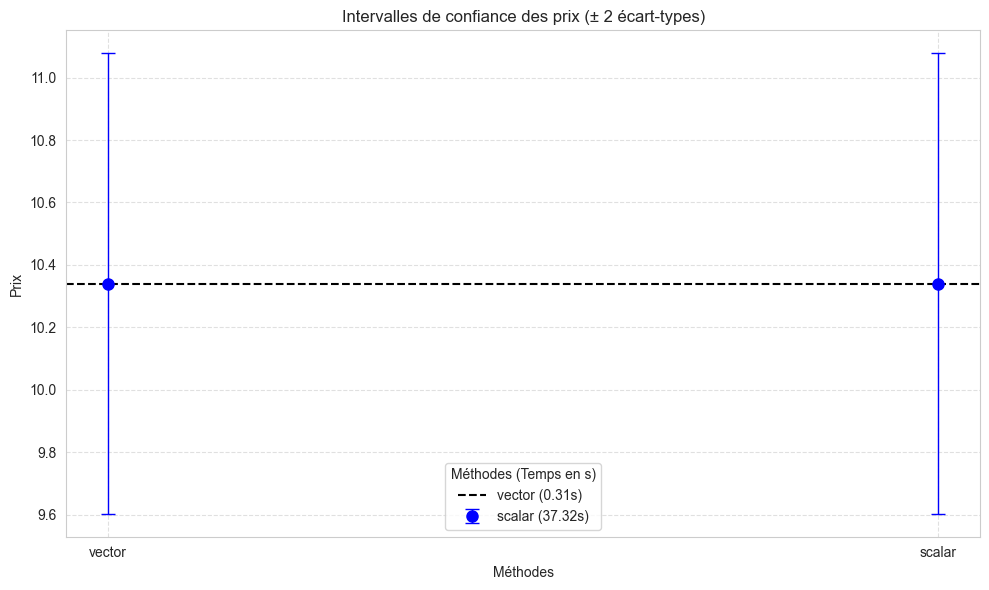

In [6]:
# Pour comparer les méthodes vectorielle et scalaire
fig_methodes = lsm_graph.comparer_methodes()
fig_methodes.show()

C:\Users\User\AppData\Local\Temp\ipykernel_52056\3747429262.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_seeds.show()


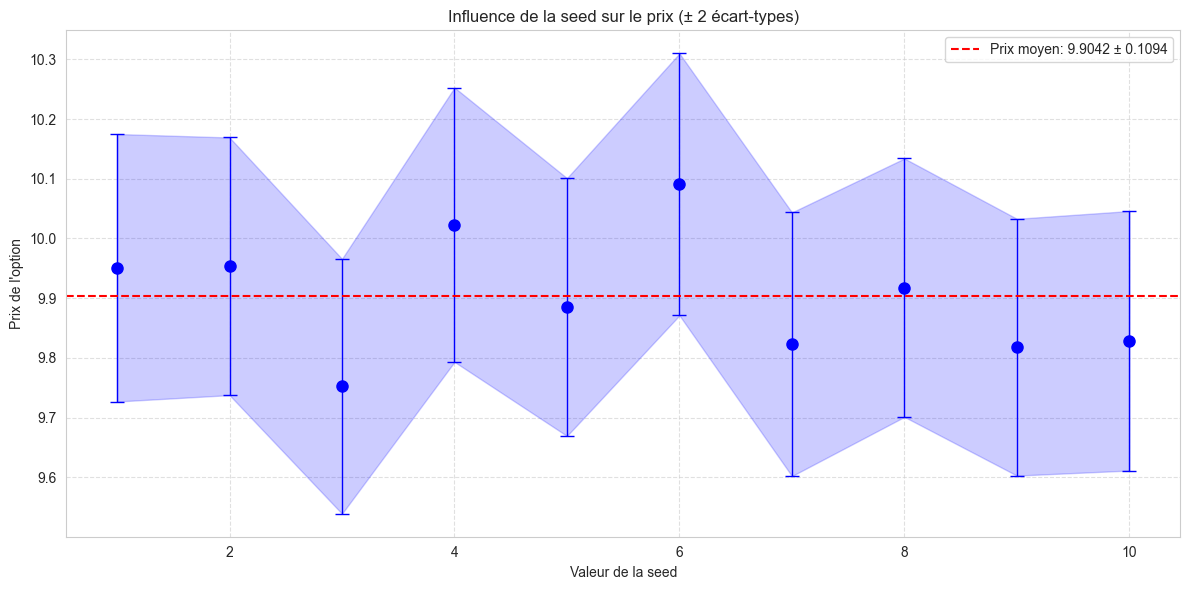

In [ ]:
# Pour comparer les prix avec différentes seeds
fig_seeds = lsm_graph.comparer_seeds()
fig_seeds.show()

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\polynomial\polynomial.py:1436: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\polynomial\polynomial.py:1436: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\polynomial\polynomial.py:1436: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\polynomial\polynomial.

                 Model      Price  Std Error  Time (s)
0   Polynomial (deg=2)   9.950933   0.112056  0.795608
1   Polynomial (deg=3)   9.934958   0.111496  0.889833
2   Polynomial (deg=4)   9.946619   0.110944  0.644241
3   Polynomial (deg=5)   9.953239   0.111741  0.856424
4   Polynomial (deg=6)  10.012112   0.112093  0.975281
5   Polynomial (deg=7)  10.001539   0.112781  0.886156
6             Laguerre   9.950933   0.112056  0.700063
7              Hermite   9.950933   0.112056  0.597073
8               Linear   9.929511   0.116487  0.728707
9          Logarithmic   9.927622   0.107813  0.644477
10         Exponential   9.547119   0.131778  0.804244


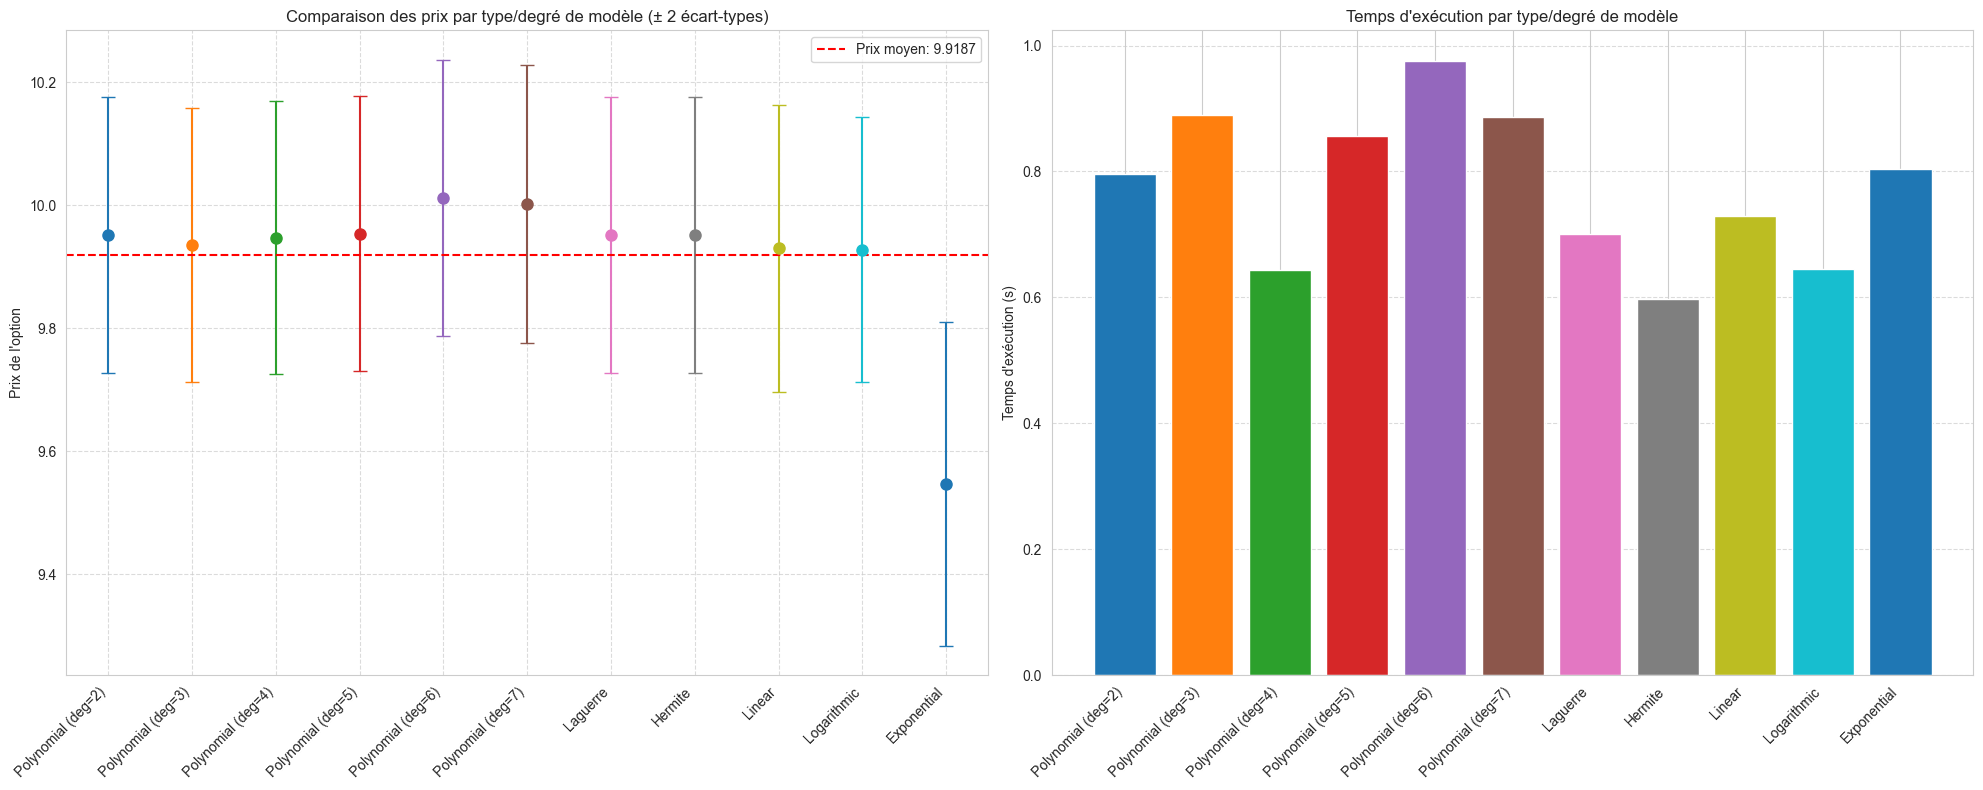

In [6]:
# Pour comparer les prix avec différents polynômes et différents degrés
fig_polys, df_results = lsm_graph.comparer_polynomes()
fig_polys.show()
print(df_results)  